In [4]:
import random
from functools import reduce
from collections import Counter
import numpy as np
import pandas as pd
import torch
import scipy.stats
import sklearn.metrics
import plotly.graph_objects as go
from tqdm.auto import tqdm, trange
from word2mat import Dataset, Sentence
from collections import Counter
import pickle
from sentence_transformers import SentenceTransformer
import os


model = SentenceTransformer('paraphrase-distilroberta-base-v1')

sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print(np.shape(embedding))
    print("")

2021-05-18 10:39:31,779 : INFO : Load pretrained SentenceTransformer: paraphrase-distilroberta-base-v1
2021-05-18 10:39:31,781 : INFO : Did not find folder paraphrase-distilroberta-base-v1
2021-05-18 10:39:31,782 : INFO : Search model on server: http://sbert.net/models/paraphrase-distilroberta-base-v1.zip
2021-05-18 10:39:31,797 : INFO : Load SentenceTransformer from folder: /home/jupyter/.cache/torch/sentence_transformers/sbert.net_models_paraphrase-distilroberta-base-v1
2021-05-18 10:39:32,894 : INFO : Use pytorch device: cpu



Sentence: This framework generates embeddings for each input sentence
(768,)

Sentence: Sentences are passed as a list of string.
(768,)

Sentence: The quick brown fox jumps over the lazy dog.
(768,)



In [5]:
full_dataset = Dataset.from_huggingface("wiki_auto", config="manual", column="normal_sentence")
len(full_dataset)

2021-05-18 10:39:33,402 : WARNING : Reusing dataset wiki_auto (/home/jupyter/.cache/huggingface/datasets/wiki_auto/manual/1.0.0/5ffdd9fc62422d29bd02675fb9606f77c1251ee17169ac10b143ce07ef2f4db8)


373801

In [5]:
clean_dataset = full_dataset.clean
len(clean_dataset)

2021-05-18 10:39:33,402 : WARNING : Reusing dataset wiki_auto (/home/jupyter/.cache/huggingface/datasets/wiki_auto/manual/1.0.0/5ffdd9fc62422d29bd02675fb9606f77c1251ee17169ac10b143ce07ef2f4db8)


373801

Sentence(words=('the', 'local', 'government', 'act', '1985', 'is', 'an', 'act', 'of', 'parliament', 'in', 'the', 'united', 'kingdom', '.'))
15
the local government act 1985 is an act of parliament in the united kingdom .



(768,)


In [78]:
def sentence_vector(sentence):
    words = ' '.join(list(sentence.words))
    BERT_vecs=(model.encode(words))
    return torch.from_numpy(BERT_vecs)
sample=sentence_vector(Sentence.from_string("Mary had a little lamb."))
sample.shape

torch.Size([768])

In [79]:
def sample_sentence_vector():
    list_of_sentences=[]
    batch_size=1000
    counter=1
    result_initialised=False
    offset=0
    for sentence in tqdm(clean_dataset.sentences):
        words = ' '.join(list(sentence.words))
        list_of_sentences.append(words)
        if counter==batch_size:
            BERT_vecs= np.array((model.encode(list_of_sentences)))
            if result_initialised:
                result_array=np.concatenate((BERT_vecs,result_array),axis=0)
            else:
                result_array=BERT_vecs
                result_initialised=True
            print(np.shape(result_array))

            list_of_sentences=[]
            counter=1
        else:
            counter+=1
    file_name='BERT_vectors_true'
    pickle_out = open(file_name+".pickle","wb")
    pickle.dump(result_array, pickle_out)
    pickle_out.close()

    
    return result_array

BERT_vectors_true=sample_sentence_vector()


(1000, 768)



(2000, 768)



In [80]:
word_counts = Counter(word for sentence in clean_dataset for word in sentence.words)
sampleable_words = list(word_counts.keys())
cum_weights = np.cumsum(list(word_counts.values()))

def random_word():
    return random.choices(sampleable_words, cum_weights=cum_weights)[0]

random_word()

'of'

In [81]:
def fake_sentence(num_fake_words=1):
    words = list(random.choice(clean_dataset.sentences).words)
    for fake_idx in range(num_fake_words):
        words[random.randrange(len(words))] = random_word()
    return Sentence(words=words)

fake_sentence()

Sentence(words=['in', 'the', '2012', 'census', ',', 'a', 'majority', 'of', 'residents', 'listed', 'their', 'nationality', 'as', 'falkland', 'islander', '(', '59', 'percent', ')', ',', 'followed', 'by', 'british', '(', '29', 'percent', ')', ',', 'saint', 'helenian', '(', '9', '.', '8', 'and', ')', ',', 'and', 'chilean', '(', '5', '.', '4', 'percent', ')', '.'])

In [82]:
def sample_sentence_vector_fake(fake_size):
    list_of_sentences=[]
    batch_size=1000
    counter=1
    result_initialised=False
    offset=0
    for i in tqdm(range(fake_size)):
        sentence=fake_sentence()
        words = ' '.join(list(sentence.words))
        list_of_sentences.append(words)
        if counter==batch_size:
            BERT_vecs= np.array((model.encode(list_of_sentences)))
            if result_initialised:
                result_array=np.concatenate((BERT_vecs,result_array),axis=0)
            else:
                result_array=BERT_vecs
                result_initialised=True
            print(np.shape(result_array))

            list_of_sentences=[]
            counter=1
        else:
            counter+=1
    file_name='BERT_vectors_fake'
    pickle_out = open(file_name+".pickle","wb")
    pickle.dump(result_array, pickle_out)
    pickle_out.close()

    
    return result_array


fake_size=len(clean_dataset)

BERT_vectors_fake=sample_sentence_vector_fake(fake_size)


(1000, 768)



(2000, 768)



In [83]:
from sklearn.model_selection import train_test_split
BERT_vectors=np.squeeze(np.concatenate((np.array(BERT_vectors_true),np.array(BERT_vectors_fake)),0))
true_labels=[1 for i in range(BERT_vectors_true.shape[0])]
fake_labels=[0 for i in range(BERT_vectors_fake.shape[0])]
labels=true_labels+fake_labels
print(np.shape(labels))
print(np.shape(BERT_vectors))
xtrain, xvalid, ytrain, yvalid = train_test_split(BERT_vectors, 
                                                  labels,  
                                                  random_state=42, 
                                                  test_size=0.2)

(4000,)
(4000, 768)


In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)
preds_train = lreg.predict(xtrain)
pred_probabilities_train=lreg.predict_proba(xtrain)
print(sklearn.metrics.precision_score(ytrain, preds_train))
preds_valid = lreg.predict(xvalid)
pred_probabilities_valid=lreg.predict_proba(xvalid)
print(sklearn.metrics.precision_score(yvalid, preds_valid))

0.9624615384615385
0.8823529411764706


In [85]:
auc = sklearn.metrics.roc_auc_score(
    yvalid,
    pred_probabilities_valid[:,1],
)
print(auc)

0.9566939993480277


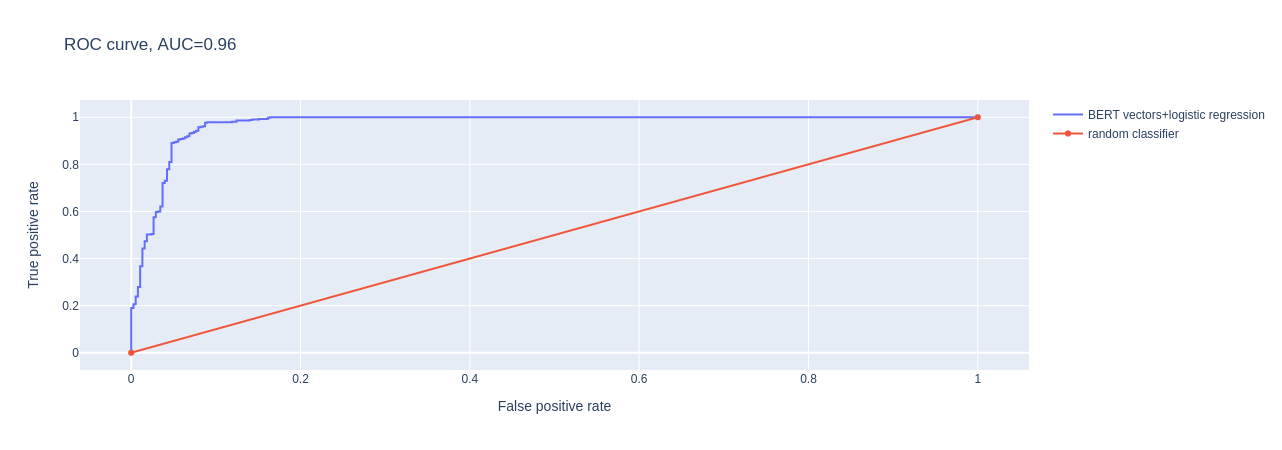

In [86]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    yvalid,
    pred_probabilities_valid[:,1],
)
go.Figure(
    layout=dict(
        title=f"ROC curve, AUC={auc:.2f}",
        xaxis_title="False positive rate",
        yaxis_title="True positive rate",
    ),
    data=[
        go.Scatter(name="BERT vectors+logistic regression", x=fpr, y=tpr),
        go.Scatter(name="random classifier", x=[0, 1], y=[0, 1])
    ],
)